In [1]:
#import struct
import os
#from joblib import Parallel, delayed
#import multiprocessing
import pickle
import cv2
from tqdm import tqdm
import ruptures as rpt
import scipy
from changepointClasses import * 
from deblurByTwosCode import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def videoToFlux(video, lower=1e4,upper=1e8):
    return ((np.array(video,dtype=float)/255))*(upper-lower)+lower
        
def genFluxArray(vidName):
    cap = cv2.VideoCapture(vidName)
    vidArray=[]
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        if np.shape(frame) ==():
            break
        frame=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        vidArray.append(videoToFlux(frame))
    cap.release()
    return np.array(vidArray)

def makeMeasurement(fluxArray,T,photsPerFrame,Nbins):
    bins = np.linspace(0,T,Nbins)
    bins=np.append(bins,T*1.01)
    measure =[]
   
    for fr in fluxArray:
        for _ in range(photsPerFrame):
            measure.append(np.digitize(np.random.exponential(1/fr),bins))
    measure=np.array(measure)  
   
    return measure
def addBlock(bl,gts,xs,ys):
    sh = np.shape(bl)
    for i in range(len(gts)):
        mask = bl !=0
        gts[i,int(ys[i]+.5):int(ys[i]+.5)+sh[0],int(xs[i]+.5):int(xs[i]+.5)+sh[1]]=bl+(1-mask)*gts[i,int(ys[i]+.5):int(ys[i]+.5)+sh[0],int(xs[i]+.5):int(xs[i]+.5)+sh[1]]
    return gts

In [3]:
cap = cv2.VideoCapture('2cars2.mp4')
trueFlux=[]
ret=True
while(ret):
    ret, frame = cap.read()
    if not ret:
        break
    trueFlux.append(frame)
    
cap.release()
trueFlux=np.array(trueFlux)

trueFlux=trueFlux[0:-10,300:,200:800,2]

In [4]:
np.shape(trueFlux)

(69, 420, 600)

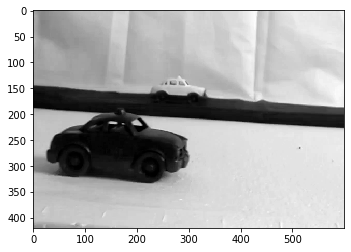

In [5]:
plt.figure()
plt.imshow(trueFlux[0],"gray")

In [7]:
gt = []
for frame in trueFlux:
    #gt.append(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
    gt.append(frame)
gt=np.array(gt)
gt = gt[:,::2,::2]


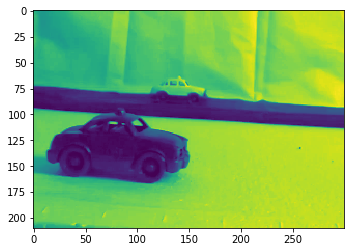

In [10]:
plt.figure()
plt.imshow(gt[0])

In [11]:
upper=1e6
lower=1e5

gtFlux=videoToFlux(gt+10,lower,upper)
bins= 8000
period = 1e-6

phots = makeMeasurement(gtFlux,period,10,bins)

In [12]:
np.shape(phots)

(690, 210, 300)

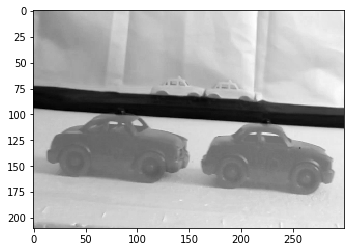

In [13]:
plt.figure()
plt.imshow(gtFlux[0]+gtFlux[-1],"gray")

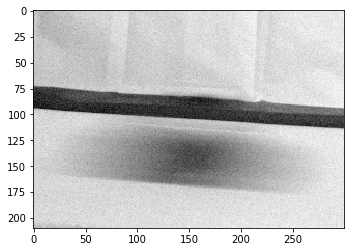

In [14]:
plt.figure()
plt.imshow(np.log10(sum(phots<bins+1)/sum(phots)),"gray")

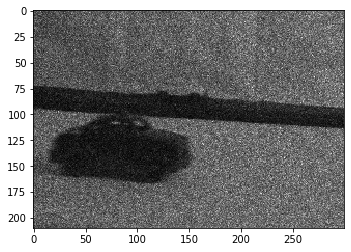

In [15]:
ind=30
o=0
plt.figure()
plt.imshow((sum(phots[o:o+ind]<=8000)/sum(phots[o:o+ind])),"gray")

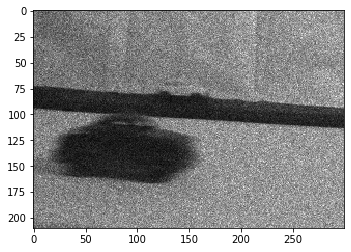

In [16]:
ind=75
o=0
plt.figure()
plt.imshow((sum(phots[o:o+ind]<=8000)/sum(phots[o:o+ind])),"gray")

In [22]:
np.shape(phots)

(690, 210, 300)

In [17]:
plt.close('all')

In [37]:
si = ChangepointVideo(phots,period,bins,penalty=6,cpSolver="pelt")
si.run_parallel(32)


100%|██████████| 210/210 [02:31<00:00,  1.39it/s]


<IPython.core.display.Javascript object>


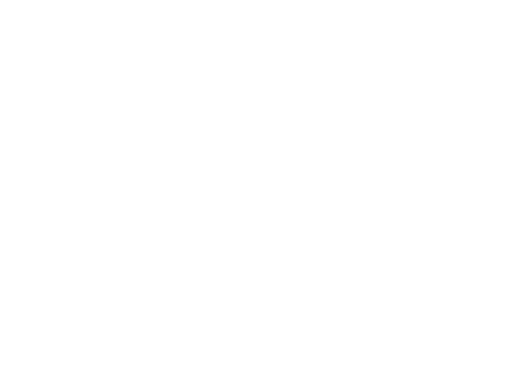

In [38]:
plt.figure()
plt.imshow(np.log10(si.getFluxFrame(200)),"gray")

In [39]:
from sklearn.cluster import DBSCAN
from mpl_toolkits import mplot3d
%matplotlib notebook

In [40]:
cps=si.getChangePoints()


<IPython.core.display.Javascript object>


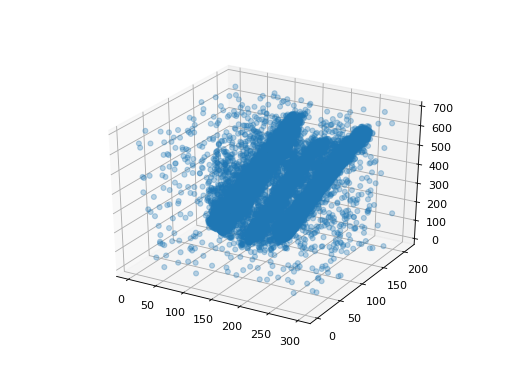

In [41]:
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata=cps[:,2]
xdata=cps[:,1]
ydata=cps[:,0]
ax.scatter3D(xdata, ydata, zdata,alpha=.3)


In [42]:
clustering = DBSCAN(eps=7.5, min_samples=40).fit(cps*[1,1,.01])
clustering.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [43]:
np.unique(clustering.labels_)

array([-1,  0,  1])

In [44]:
[sum(clustering.labels_==i) for i in np.unique(clustering.labels_)]

[543, 649, 17243]

<IPython.core.display.Javascript object>


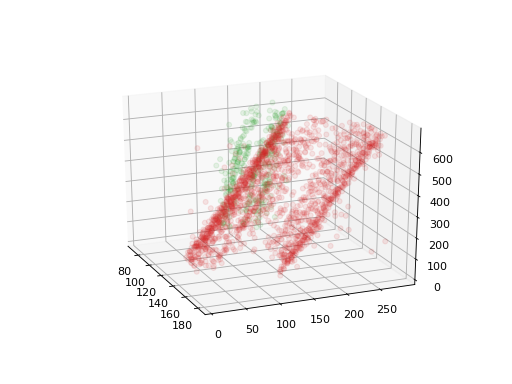

In [45]:
img = cv2.cvtColor(normalize0(gt[0]**.4),cv2.COLOR_GRAY2BGR)/255
x, y = np.ogrid[:img.shape[0], :img.shape[1]]

fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.plot_surface(x, y, -15*np.ones((len(x),len(y))), rstride=1, cstride=1, facecolors=img)

cps1=cps[clustering.labels_==1]
zdata=cps1[::10,2]
ydata=cps1[::10,1]
xdata=cps1[::10,0]


ax.scatter3D(xdata, ydata, zdata,alpha=.1,color='C3')

cps2=cps[clustering.labels_==0]
zdata=cps2[::2,2]
ydata=cps2[::2,1]
xdata=cps2[::2,0]

ax.scatter3D(xdata, ydata, zdata,alpha=.1,color='C2')
ax.view_init(elev=68., azim=-55)


In [46]:
#plt.savefig("cars_clusterd.png",dpi=1200)

<IPython.core.display.Javascript object>


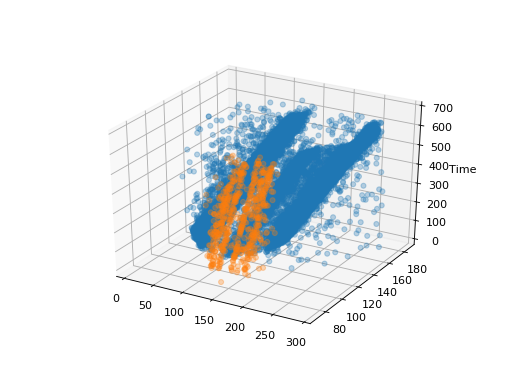

Text(0.5, 0, 'Time')

In [47]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cps1=cps[clustering.labels_==1]
zdata=cps1[:,2]
xdata=cps1[:,1]
ydata=cps1[:,0]


ax.scatter3D(xdata, ydata, zdata,alpha=.3)

cps2=cps[clustering.labels_==0]
zdata=cps2[:,2]
xdata=cps2[:,1]
ydata=cps2[:,0]

ax.scatter3D(xdata, ydata, zdata,alpha=.3)

ax.set_zlabel("Time")


In [48]:
#plt.savefig("changepoint_2cars_cluster.svg")

In [51]:
def get_Bounding(toBound,sh=(210,347),d=10):
    b1max=np.max(toBound,axis=0)
    b1min=np.min(toBound,axis=0)
    b1min = [np.max([b1min[0]-d,0]),np.max([b1min[1]-d,0])]
    
    b1max = [np.min([b1max[0]+d,sh[0]]),np.min([b1max[1]+d,sh[1]])]
    return b1max,b1min

In [52]:
def normalize0(array):
    array=np.nan_to_num(array)
    return np.nan_to_num(normalize(cutNorm(array)))


In [53]:
def deblurByTwosStart_VFR_Clusters(si,cps,clustering,cpsPercent,photsInput,areaMin=20,lengthMin= 10, n_cores=4,padding=10,flux_func=flux_timing,timeIn_o=None,NIn_o=None):
    if timeIn_o is None or NIn_o is None:
        timeIn_o,NIn_o=convertFanData(photsInput)
    outArray=[]
    sh = np.shape(si.singlePixels)
    print(sh)
    for label in np.unique(clustering.labels_)[0:3]:
        if label>-1:
            cpsC=cps[clustering.labels_==label]

            cpInc = 1
            cpsSort = cpsC[cpsC[:,2].argsort()]
            cpsTimes = cpsSort[:,2]
            
            tMax = cpsTimes[-1]
            cpMin = len(cpsC)/10
            indeces = [0]
            currCP=0
            lastCP=0
            done=False
            imgs=[]   
            while not done:
                currCP += cpInc

                if currCP>=len(cpsTimes):
                    currCP = len(cpsTimes)-1

                ind = cpsTimes[currCP]
                currCP = np.where(cpsTimes==ind)[0][-1]

                bmax,bmin = get_Bounding(cpsSort[lastCP:currCP],sh)
                cpNeed = (bmax[0]-bmin[0])*(bmax[1]-bmin[1])*cpsPercent
                if currCP-lastCP >cpNeed and currCP-lastCP>cpMin :
                    #bmax,bmin = get_Bounding(cpsSort,sh)
                    cropSi=si.getFluxFrame(ind)[bmin[0]:bmax[0],bmin[1]:bmax[1]]
                        
                    img=np.ones(sh)*np.min(cropSi)
                    img[bmin[0]:bmax[0],bmin[1]:bmax[1]]=cropSi
                    imgs.append(img)
                    
                    indeces.append(ind)
                    lastCP=currCP

                if currCP >= len(cpsTimes)-1:
                    done=True
            if tMax+50>=len(phots):
                indeces.append(tMax)
                cropSi=si.getFluxFrame(tMax)[bmin[0]:bmax[0],bmin[1]:bmax[1]]
                img=np.ones(sh)*np.min(cropSi)
                img[bmin[0]:bmax[0],bmin[1]:bmax[1]]=cropSi
                imgs.append(img)
            
            print(indeces)
            bmax,bmin = get_Bounding(cpsSort,sh)
            NIn=NIn_o[:,bmin[0]:bmax[0],bmin[1]:bmax[1]]
            timeIn= timeIn_o[:,bmin[0]:bmax[0],bmin[1]:bmax[1]]
            imgs = np.array(imgs)[:,bmin[0]:bmax[0],bmin[1]:bmax[1]]
            imgs = normalize0(imgs)
            
            imgs=np.pad(imgs,((0,0),(padding,padding),(padding,padding)),"constant",constant_values=np.min(imgs))
            NIn=np.pad(NIn,((0,0),(padding,padding),(padding,padding)),"constant")
            timeIn=np.pad(timeIn,((0,0),(padding,padding),(padding,padding)),"constant", constant_values=1)
            temp=Parallel(n_jobs=n_cores)(delayed(parallel_block_phots)(imgs[i:i+2],indeces[i+1]-indeces[i],timeIn[indeces[i]:indeces[i+1]],NIn[indeces[i]:indeces[i+1]],flux_func)for i in range(0,len(imgs)-1))
    
            temp=np.array(temp)
            vids=[]
            for i in temp[:,0]:
                vids.append(i)
            vids=np.array(vids)
            outS=[]
            for i in temp[:,1]:
                outS.append(i)
            outS=np.array(outS)
            Nouts=[]
            for i in temp[:,2]:
                Nouts.append(i)
            Nouts=np.array(Nouts)
            warps=[]
            for i in temp[:,3]:
                warps.append(i)
            warps=np.array(warps)

            vids = np.nan_to_num(vids)
                #vids=np.flip(vids,0)
                #outS=np.flip(outS)
                #Nouts = np.flip(Nouts)
            print(np.shape(vids))


            print("looping")

            while(len(vids)>1):
                #imgs = imgs[::2]
                #vids,outS,Nouts = deblurByTwos(imgs,outS,Nouts)
                temp=Parallel(n_jobs=n_cores)(delayed(parallel_block_no_phots)(vids[i:i+2],outS[i:i+2],Nouts[i:i+2],warps[i:i+2],flux_func)for i in range(0,len(vids)-1,2))
                temp=np.array(temp)
                vids=[]
                for i in temp[:,0]:
                    vids.append(i)
                
                outS=[]
                for i in temp[:,1]:
                    outS.append(i)
                outS=np.array(outS)
                Nouts=[]
                for i in temp[:,2]:
                    Nouts.append(i)
                Nouts=np.array(Nouts)
                warps=[]
                for i in temp[:,3]:
                    warps.append(i)
                warps=np.array(warps)
                for i in range(0,len(vids)-1,2):
                    ws=warps[i:i+2]
                    if len(ws)==2:
                        temp=np.pad(ws,((0,0),(0,1),(0,0)))
                        temp[:,-1,-1]=1
                        temp=(temp[0]@temp[1])[:2,:]
                        warps[i]=temp
                        warps[i+1]=temp

                vids = np.nan_to_num(vids)
                print(np.shape(vids))
                #if len(vids)==4:
                   # return vids,warps
            toAppend= [vids, outS,Nouts]
            outArray.append(toAppend)
    return outArray

In [54]:
timeIn_o,NIn_o=convertFanData(phots)

In [55]:
results = deblurByTwosStart_VFR_Clusters(si,cps,clustering,.01,phots,n_cores=30,timeIn_o=timeIn_o,NIn_o=NIn_o,padding=0)

(210, 300)
[0, 142, 192, 252, 303, 351, 409, 452, 515, 570, 657]
(9, 47, 121)
looping
(4, 47, 121)
(2, 47, 121)
(1, 47, 121)
[0, 113, 172, 234, 294, 354, 413, 472, 531, 588, 671]
(9, 109, 299)
looping
(4, 109, 299)
(2, 109, 299)
(1, 109, 299)


<IPython.core.display.Javascript object>


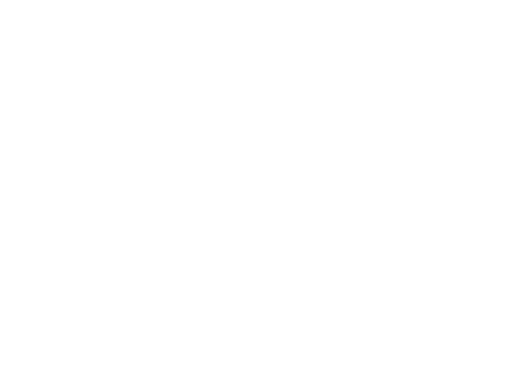

/ua/seets/motionDeblur/simulation250ps/CleanedUpClasses/deblurByTwosCode.py:41: RuntimeWarning: invalid value encountered in true_divide
  return N/t


In [56]:
plt.figure()

plt.imshow(flux_timing(results[0][2][0],results[0][1][0]*period/bins ))

<IPython.core.display.Javascript object>


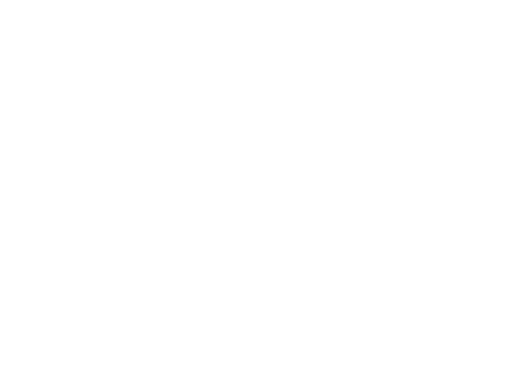

In [57]:
plt.figure()
plt.imshow((results[1][0][0]))

<IPython.core.display.Javascript object>


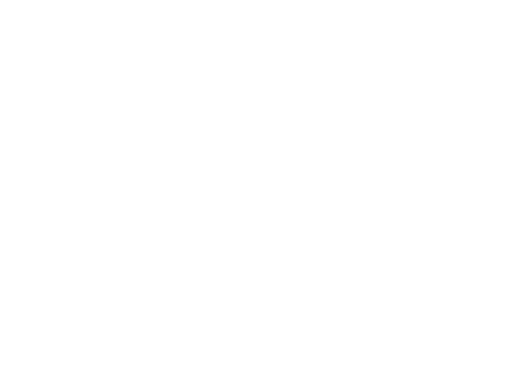

In [58]:
photsGT =  makeMeasurement([gtFlux[0]],period,820,bins)
plt.figure()
plt.imshow(sum(photsGT<bins+1)/sum(photsGT), "gray")

In [60]:
#toshow = si.getFluxFrame(100)
toshow = sum(phots<=8000)/(sum(phots) *period/bins)

In [61]:
padding=0
for i in range(len(results)):
    if i>-1:
        cpsC=cps[clustering.labels_==i]
        cpsSort = cpsC[cpsC[:,2].argsort()]
       
        img = flux_timing(results[i][2][0],results[i][1][0] *period/bins)
        img = img[:,:-10]
        temp=np.zeros_like(toshow)
        bmax,bmin = get_Bounding(cpsSort)
        bmax =[bmax[0],bmax[1]-10]
        temp[bmin[0]:bmax[0],bmin[1]:bmax[1]]=img
        bmax,bmin = get_Bounding(cpsSort)
        bmax =[bmax[0],bmax[1]-10]
        toshow[bmin[0]:bmax[0],bmin[1]:bmax[1]] = temp[bmin[0]:bmax[0],bmin[1]:bmax[1]]

<IPython.core.display.Javascript object>


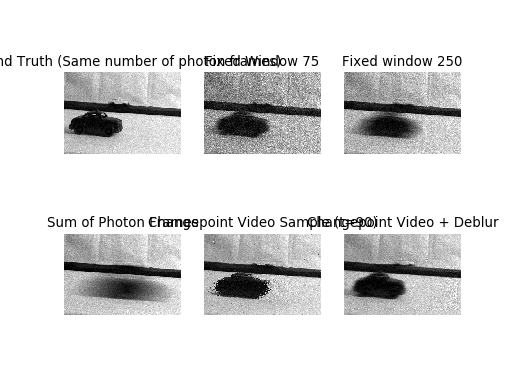

(-0.5, 294.5, 205.5, -0.5)

In [62]:
fig,axs=plt.subplots(2,3)

axs[0,0].imshow(normalize0(sum(photsGT<bins+1)/sum(photsGT)),"gray")
axs[0,0].set_title("Ground Truth (Same number of photon frames)")

ind=75
o=50
axs[0,1].imshow((normalize0(sum(phots[o:o+ind]<=8000)/sum(phots[o:o+ind])/1e-12)),"gray")
axs[0,1].set_title("Fixed Window 75")

ind=250
axs[0,2].imshow((normalize0(sum(phots[o:o+ind]<=8000)/sum(phots[o:o+ind])/1e-12)),"gray")
axs[0,2].set_title("Fixed window 250")



axs[1,2].imshow(normalize0(toshow[2:-2,2:-3]),"gray")
axs[1,2].set_title("Changepoint Video + Deblur")
ind=20000
axs[1,0].imshow((normalize0(sum(phots[o:o+ind]<=8000)/sum(phots[o:o+ind])/1e-12)),"gray")
axs[1,0].set_title("Sum of Photon Frames")
axs[1,1].imshow(normalize0(si.getFluxFrame(90)[2:-2,2:-3]),"gray")
axs[1,1].set_title("Changepoint Video Sample (t=90)")

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')

In [54]:
#plt.savefig("2cars_comparison_bottomup.svg")

In [63]:
def get_edges_fixed(signal,burst,z=2.58,d=1):
    sigBurst = []
    signal = signal[:int(len(signal)/burst)*burst]
    for i in range(0,len(signal),burst):
        sigBurst.append(sum(signal[i:i+burst]))
    sigBurst = np.array(sigBurst)
    pSquig = (sigBurst + z**2/2)/(burst+z**2)
    pMax = pSquig + z*np.sqrt((pSquig*(1-pSquig))/(burst+z**2))
    pMin = pSquig - z*np.sqrt((pSquig*(1-pSquig))/(burst+z**2))
    changes =[]
    for i in range(d,len(pMax)):
        if pMin[i]>pMax[i-d] or pMax[i]<pMin[i-d]:
            changes.append(i*burst)

    return changes

In [64]:
burst =100
N=phots<=8000
sh = np.shape(phots)
diffFrames=np.zeros((sh[1],sh[2],int(sh[0]/burst)))

for i in tqdm(range(sh[1])):
    for j in range(sh[2]):
        chgs = get_edges_fixed(N[:,i,j],burst)
        for c in chgs:
            diffFrames[i,j,int(c/burst)]=1
diffFrames=diffFrames[:,:,1:]

100%|██████████| 210/210 [04:05<00:00,  1.17s/it]


<IPython.core.display.Javascript object>


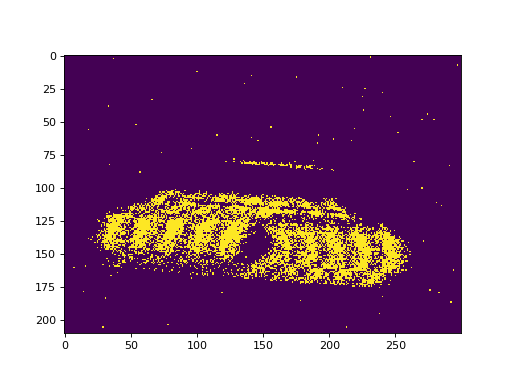

In [65]:
plt.figure()
plt.imshow(normalize0(np.sum(diffFrames[:,:,:],axis=2)))

In [66]:
diffCps=np.where(diffFrames==1)
diffCps = np.transpose(diffCps)


In [67]:
diffCps

array([[  1, 231,   4],
       [  2,  37,   3],
       [  7, 297,   4],
       ...,
       [203,  78,   4],
       [205,  29,   2],
       [205, 213,   4]])

In [68]:
clustering2 = DBSCAN(eps=6, min_samples=20).fit(diffCps*[1,1,1])
clustering2.labels_

array([-1, -1, -1, ..., -1, -1, -1])

<IPython.core.display.Javascript object>


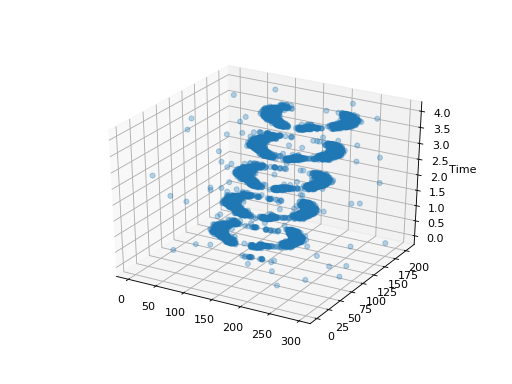

Text(0.5, 0, 'Time')

In [69]:
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata=diffCps[:,2]
xdata=diffCps[:,1]
ydata=diffCps[:,0]


ax.scatter3D(xdata, ydata, zdata,alpha=.3)


ax.set_zlabel("Time")

In [70]:
np.unique(clustering2.labels_)

array([-1,  0,  1,  2])

<IPython.core.display.Javascript object>


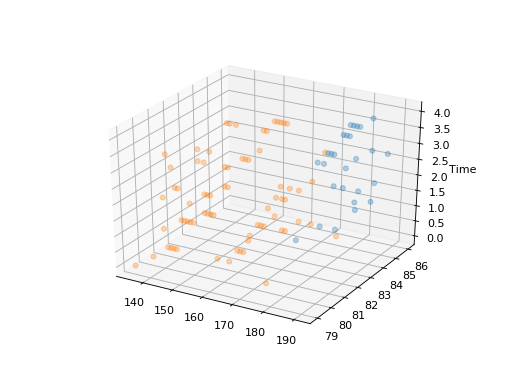

Text(0.5, 0, 'Time')

In [71]:
fig = plt.figure()
ax = plt.axes(projection='3d')
cps1=diffCps[clustering2.labels_==1]
zdata=cps1[:,2]
xdata=cps1[:,1]
ydata=cps1[:,0]


ax.scatter3D(xdata, ydata, zdata,alpha=.3)

cps2=diffCps[clustering2.labels_==0]
zdata=cps2[:,2]
xdata=cps2[:,1]
ydata=cps2[:,0]

ax.scatter3D(xdata, ydata, zdata,alpha=.3)

ax.set_zlabel("Time")


<IPython.core.display.Javascript object>


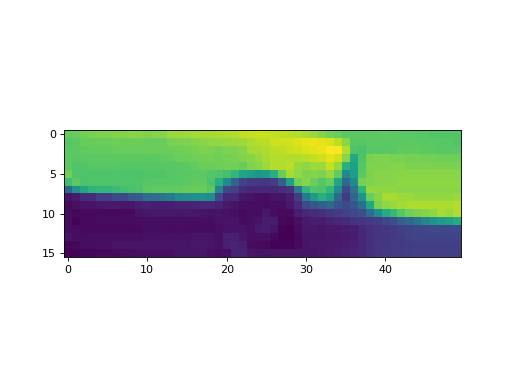

In [72]:
bmax,bmin = get_Bounding(cps2,sh,d=5)
plt.figure()
plt.imshow(gtFlux[0][bmin[0]:bmax[0],bmin[1]:bmax[1]])

In [73]:
diffCps

array([[  1, 231,   4],
       [  2,  37,   3],
       [  7, 297,   4],
       ...,
       [203,  78,   4],
       [205,  29,   2],
       [205, 213,   4]])

In [74]:
def point_cloud_tracking(pts1,pts2):

    c1 = (sum(pts1)/len(pts1))
    c2 = (sum(pts2)/len(pts2))  
    x,y,z = c2-c1
    return x,y

<IPython.core.display.Javascript object>


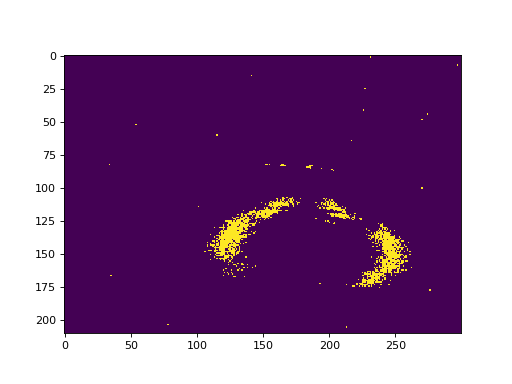

In [75]:
plt.figure()
plt.imshow(diffFrames[:,:,-1])

<IPython.core.display.Javascript object>


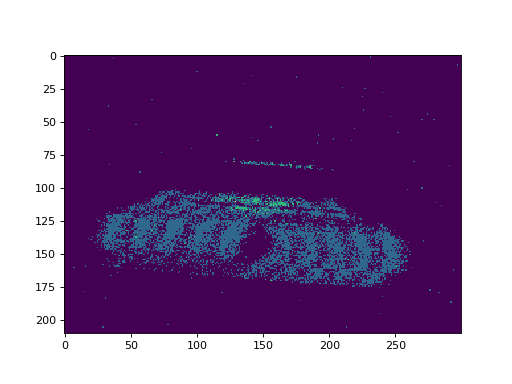

In [76]:
plt.figure()
plt.imshow(np.sum(diffFrames[:,:,:],axis=2))

In [77]:
def deblurByTwos_diffFrams(dFrames,cps,burst,clustering,photsInput, n_cores=4,padding=10,flux_func=flux_timing,timeIn_o=None,NIn_o=None):
    if timeIn_o is None or NIn_o is None:
        timeIn_o,NIn_o=convertFanData(photsInput)
    outArray=[]
    sh = np.shape(timeIn_o[0])
    print(sh)
    for label in np.unique(clustering.labels_)[:]:
        if label>-1:
            cpsC=cps[clustering.labels_==label]

            cpsSort = cpsC[cpsC[:,2].argsort()]
            cpsTimes = cpsSort[:,2]
            
            tMax = len(timeIn_o)

            indeces = []
            
            currCP=0
            lastCP=0
            done=False
            imgs=[]   
            ind=0
            
            bmax,bmin = get_Bounding(cpsSort,sh)
            
            cpsInds =  np.where(cpsTimes==0)[0]
            if len(cpsInds)==0:
                continue
            lastCP =cpsInds[-1]
            refCPS = cpsSort[:lastCP]
            currCP = lastCP
            
            bmax,bmin = get_Bounding(cpsSort,sh)
            
            while not done:
                currCP += 1

                if currCP>=len(cpsTimes):
                    currCP = len(cpsTimes)-1

                ind = ind+1
                xs = [0]
                ys=[0]
                ts=[0]
                if sum(cpsTimes==ind)>0:
                    
                    cpsInds =  np.where(cpsTimes==ind)[0]
                    if len(cpsInds)==0:
                        continue
                    currCP =cpsInds[-1]
                    currCPS = cpsSort[lastCP:currCP]
                    

                    x_translation,y_translation=point_cloud_tracking(currCPS,refCPS)
                    ts.append(ind*burst)
                    xs.append(x_translation)
                    ys.append(y_translation)
                    lastCP=currCP
                    
                if currCP >= len(cpsTimes)-1:
                    done=True
                
            x_interp=scipy.interpolate.interp1d(ts,xs)
            y_interp=scipy.interpolate.interp1d(ts,ys)
            out=np.zeros(sh)[bmin[0]:bmax[0],bmin[1]:bmax[1]]
            N=np.zeros(sh)[bmin[0]:bmax[0],bmin[1]:bmax[1]]
            sz = np.shape(N)

            for i in range(ts[-1]):
                x0 = -y_interp(i)
                x1 = -x_interp(i)
                warp_matrix=getWarpMatrixFromParams(0,x0,x1,0,0)
                o=cv2.warpAffine(timeIn_o[i][bmin[0]:bmax[0],bmin[1]:bmax[1]], warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP);
                oN=cv2.warpAffine(NIn_o[i][bmin[0]:bmax[0],bmin[1]:bmax[1]], warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP);
                out+=o
                N+=oN
            outArray.append([N,out,label])
                    
                    


        
    return outArray

In [78]:
results_diff=deblurByTwos_diffFrams(diffFrames,diffCps,burst,clustering2,phots, n_cores=30,timeIn_o=timeIn_o,NIn_o=NIn_o,padding=0)

(210, 300)


<IPython.core.display.Javascript object>


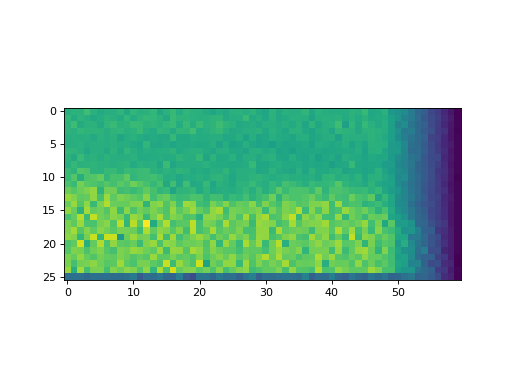

In [79]:
plt.figure()
plt.imshow(results_diff[0][1])
#plt.imshow(flux_timing(results_diff[0][0],results_diff[0][1])*period/bins)

<IPython.core.display.Javascript object>


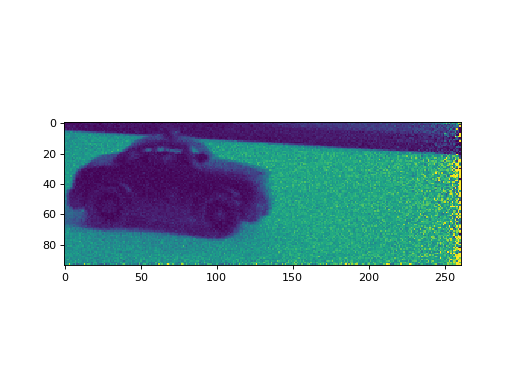

/ua/seets/motionDeblur/simulation250ps/CleanedUpClasses/deblurByTwosCode.py:41: RuntimeWarning: invalid value encountered in true_divide
  return N/t


In [80]:
plt.figure()
plt.imshow(normalize0(flux_timing(results_diff[1][0],results_diff[1][1])*period/bins))

In [81]:
#toshow = si.getFluxFrame(100)
toshow2 = sum(phots<=8000)/(sum(phots) *period/bins)

In [82]:
padding=0
for i in range(len(results_diff)):
    if i>-1:
        label = results_diff[i][2]
        cpsC=diffCps[clustering2.labels_==label]
        cpsSort = cpsC[cpsC[:,2].argsort()]
       
        img = flux_timing(results_diff[i][0],results_diff[i][1] *period/bins)
        img = img[:-5,:-20]
        temp=np.zeros_like(toshow)
        bmax,bmin = get_Bounding(cpsSort)
        bmax =[bmax[0]-5,bmax[1]-20]
        temp[bmin[0]:bmax[0],bmin[1]:bmax[1]]=img
        bmax,bmin = get_Bounding(cpsSort)
        bmax =[bmax[0]-5,bmax[1]-20]
        toshow2[bmin[0]:bmax[0],bmin[1]:bmax[1]] = temp[bmin[0]:bmax[0],bmin[1]:bmax[1]]

<IPython.core.display.Javascript object>


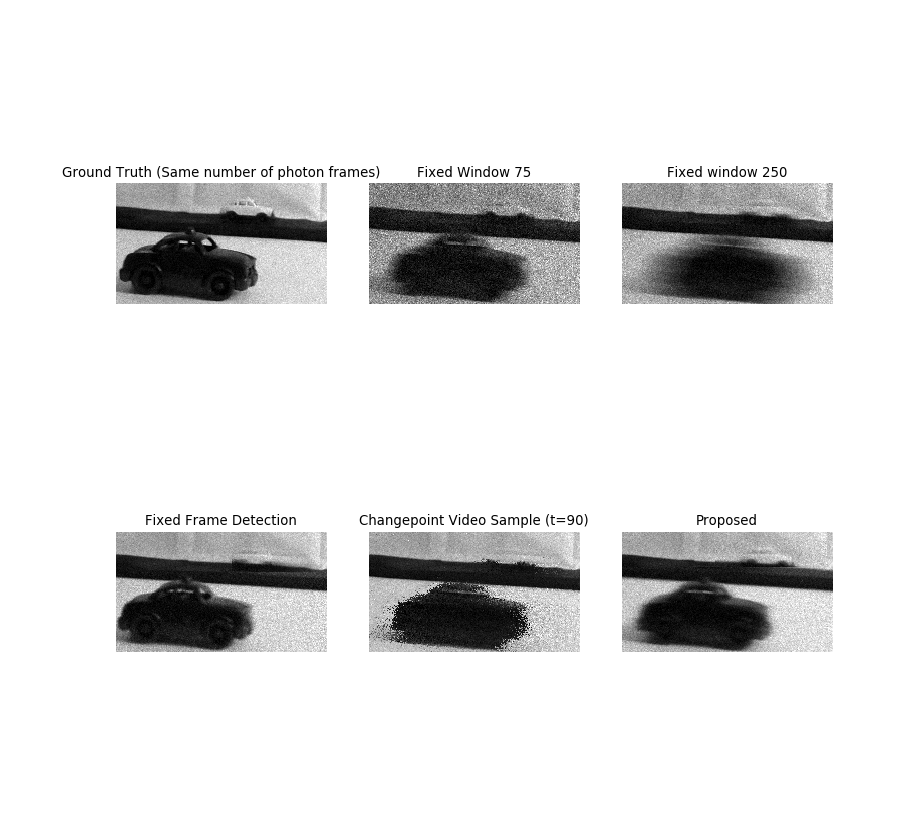

(-0.5, 209.5, 119.5, -0.5)

In [84]:
fig,axs=plt.subplots(2,3)

x1=10
x2=-80
y1=50
y2=-40

axs[0,0].imshow(normalize0(sum(photsGT<bins+1)/sum(photsGT))[y1:y2,x1:x2],"gray")
axs[0,0].set_title("Ground Truth (Same number of photon frames)")

ind=75
o=50
axs[0,1].imshow((normalize0(sum(phots[o:o+ind]<=8000)/sum(phots[o:o+ind])/1e-12))[y1:y2,x1:x2],"gray")
axs[0,1].set_title("Fixed Window 75")

ind=250
axs[0,2].imshow((normalize0(sum(phots[o:o+ind]<=8000)/sum(phots[o:o+ind])/1e-12))[y1:y2,x1:x2],"gray")
axs[0,2].set_title("Fixed window 250")



axs[1,2].imshow(normalize0(toshow[y1:y2,x1:x2]),"gray")
axs[1,2].set_title("Proposed")
ind=20000
axs[1,0].imshow((normalize0(toshow2[y1:y2,x1:x2])),"gray")
axs[1,0].set_title("Fixed Frame Detection")
axs[1,1].imshow(normalize0(si.getFluxFrame(100)[y1:y2,x1:x2]),"gray")
axs[1,1].set_title("Changepoint Video Sample (t=90)")

axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')

In [120]:
#plt.savefig("2cars2_with_priorwork_zoom.svg")